  taken on 2018-09-13T03:30:42.179Z


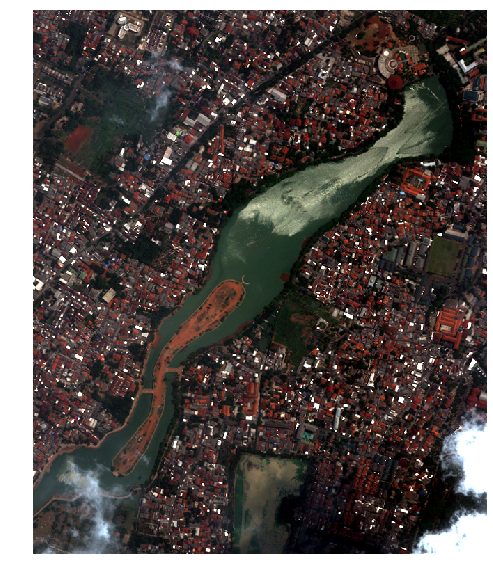

In [8]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '1030010085B5FC00')
bbox = env.inputs.get('bbox', '106.81642055511476, -6.350359691139068, 106.82757854461671, -6.336966782499579')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))

print("  taken on {}".format( image.metadata["image"]["acquisitionDate"]))


image.plot(w=10, h=10)

In [9]:
image

dask.array<getitem, shape=(8, 782, 652), dtype=float32, chunksize=(8, 256, 256)>

In [10]:
# Import metadata

print("CatID: {} instantiated as a {} {}-band raster with {} rows and {} columns".format(catalog_id, image.dtype, *image.shape))
print("  with geographic bounds: ({})".format(bbox))
print("  in projection: {}".format( image.metadata["georef"]["spatialReferenceSystemCode"]))
print("  at {:0.2f} meter resolution".format( image.metadata["image"]["groundSampleDistanceMeters"]))
print("  and {:0.2f} degrees off nadir".format( image.metadata["image"]["offNadirAngle"]))
print("  taken on {}".format( image.metadata["image"]["acquisitionDate"]))

CatID: 1030010085B5FC00 instantiated as a float32 8-band raster with 782 rows and 652 columns
  with geographic bounds: (106.81642055511476, -6.350359691139068, 106.82757854461671, -6.336966782499579)
  in projection: EPSG:4326
  at 1.91 meter resolution
  and 9.60 degrees off nadir
  taken on 2018-09-13T03:30:42.179Z


In [11]:
# Calculate image resolution
resolution = image.metadata["image"]["groundSampleDistanceMeters"]
resolution

1.906

In [12]:
# Split image into separate bands

import numpy as np

coastal = image[0,:,:].astype(np.float32)
blue = image[1,:,:].astype(np.float32)
green = image[2,:,:].astype(np.float32)
yellow = image[3,:,:].astype(np.float32)
red = image[4,:,:].astype(np.float32)
red_edge = image[5,:,:].astype(np.float32)
nir1 = image[6,:,:].astype(np.float32)
nir2 = image[7,:,:].astype(np.float32)

In [13]:
# Calculate indices 

avg = (nir1+nir2)/2
water_index = (coastal - avg)/(coastal + avg)
ndvi = (nir1 - red)/(nir1 +red)

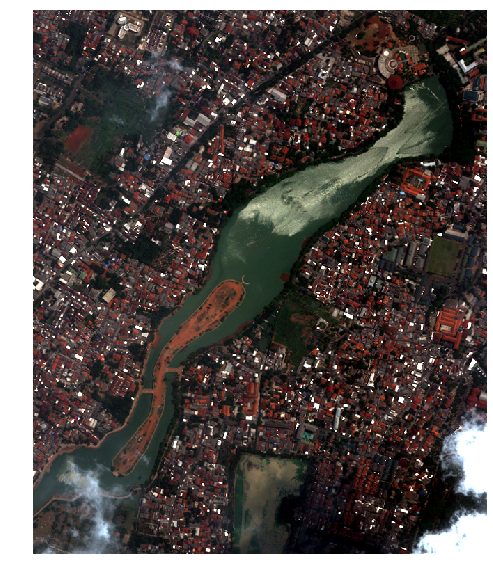

In [14]:
# Visualize image to check...
image.plot()

In [15]:
# Import packages

import cv2                     # If error: pip install opencv-python in terminal
import numpy as np
from functools import reduce
import operator
from PIL import Image

In [52]:
# Create steps so interactive plot moves to next image section

def equalize(h):

    lut = []

    for b in range(0, len(h), 256):

        # step size
        step = reduce(operator.add, h[b:b+256]) / 255

        # create equalization lookup table
        n = 0
        for i in range(256):
            lut.append(n / step)
            n = n + h[i+b]

    return lut

def next_step(band_data, n = 0, row = 0,everything = True):
    
    data_shape = band_data.shape
    
    steps = 200
    
    n_rows = int(floor(data_shape[1]/steps))
    
    n_cols = int(floor(data_shape[2]/steps))
     
    
    row = int(floor(n / n_cols))        
       
    x_s = 0 + (steps * (n - (row * n_cols) ))
    x_e = steps + (steps * (n - (row * n_cols) ))
    y_s = 0 + (steps * row)
    y_e = steps + (steps * row)
        

    bands = band_data[:,y_s:y_e,x_s:x_e]
    
    red = band_data[4,y_s:y_e,x_s:x_e]
    green = band_data[2,y_s:y_e,x_s:x_e]
    blue = band_data[1,y_s:y_e,x_s:x_e]

    rgbArray = np.zeros((y_e - y_s,x_e - x_s,3), 'uint8')

    rgbArray[..., 0] = (red/10000)*256
    rgbArray[..., 1] = (green/10000)*256
    rgbArray[..., 2] = (blue/10000)*256

    img = Image.fromarray(rgbArray)
    
    # calculate lookup table
    lut = equalize(img.histogram())

    # map image through lookup table
    img_fix = img.point(lut)
    
    if everything:
        return(img_fix, [x_s,x_e,y_s,y_e], bands)
    else:
        return(img_fix)

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


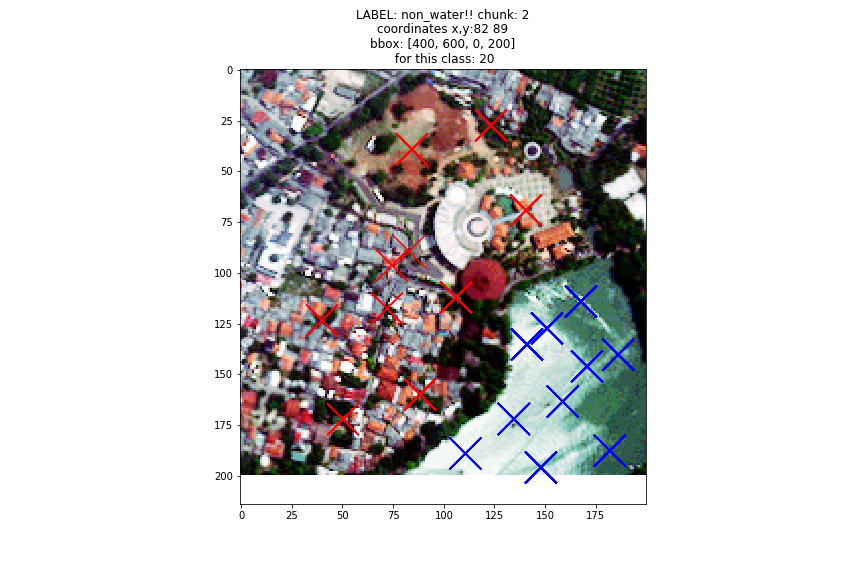

In [69]:
%pylab notebook

# Set number of samples per image chunk 
samples_chunk_init = 10 # Samples per class
classification = 'tree'



samples_chunk = (samples_chunk_init * 2) +1

band_data = np.array(image)


# Create initial plot
fig, ax = plt.subplots(figsize=(12,8))
# fig.tight_layout()
plt.title('first label a tree')
ax.imshow(next_step(band_data, n = 0, everything = False))
ax.set_frame_on(False)


# Initialize collector variable
collector = []

# Initialize other variables for saving data 
x_save = []
y_save = []
label_save = []

x = []
y = []
bands_save = []
label_chunk_save = []

# Initial chunk counting arrays
counter = []
counter_cumsum = []

def onclick(event):
    
    # Get data from event
    collector.append('button=%d, x=%d, y=%d, xdata=%f, ydata=%f'%(
        event.button, event.x, event.y, event.xdata, event.ydata))

    # Save data to xy
    x.append(event.xdata)
    y.append(event.ydata)
    
    # Create steps
    counter.append((len(x)%samples_chunk == 0) & (len(x) > 0))
    counter_cumsum = np.cumsum(counter)
    n = counter_cumsum[len(counter_cumsum) - 1]
    
    # Check of number of samples has been reached
    sample_check = not((len(x)%samples_chunk == 0) & (len(x) > 0))
        
    if sample_check:

        img, bbox, bands = next_step(band_data, n = n, everything = True)       
        
        x_save.append(int(event.xdata) + bbox[0])
        y_save.append(int(event.ydata) + bbox[2])
        
        bands_save.append(bands[:,int(event.ydata),int(event.xdata)])
        
        if len(x) <= samples_chunk_init:
            label = 'water'
        elif len(x) <= samples_chunk_init * 2:
            label = 'non_water'
#         elif len(x) <= samples_chunk_init * 3:
#             label = 'tree'
#         elif len(x) <= samples_chunk_init * 4:
#             label = 'grass'
#         elif len(x) <= samples_chunk_init * 5:
#             label = 'street'
            
        
        label_save.append(label)
        label_chunk_save.append(label)
        
        non_water = [i for i, e in enumerate(label_chunk_save) if e == 'non_water']
        # trees = [i for i, e in enumerate(label_chunk_save) if e == 'tree']
        water = [i for i, e in enumerate(label_chunk_save) if e == 'water']
#         grass = [i for i, e in enumerate(label_chunk_save) if e == 'grass']
#         street = [i for i, e in enumerate(label_chunk_save) if e == 'street']
        

        x_array = np.array(x)
        y_array = np.array(y)
            
            
        txt_label = ['LABEL: ' + label + '!! chunk: ' + str(n)  + '\ncoordinates x,y:' + 
                  str(int(x[len(x)-1])) + ' '+ str(int(y[len(y)-1])) + 
                 '\nbbox: ' + str(bbox) + 
                 '\n band data :' + str(bands[:,int(event.ydata),int(event.xdata)])]
        
        plt.imshow(img)
        s = [20*4**n for n in range(len(non_water))]
        
        plt.scatter(x_array[non_water],y_array[non_water], color = 'red',marker= "x", s = zeros(len(non_water))  + 1000)
        #plt.scatter(x_array[trees],y_array[trees], color = 'darkgreen', marker= "x", s = ones(len(trees)) * 100)
        plt.scatter(x_array[water],y_array[water], color = 'blue', marker= "x",s = zeros(len(water))  + 1000)
        #plt.scatter(x_array[grass],y_array[grass], color = 'lightgreen')
        #plt.scatter(x_array[street],y_array[street], color = 'grey')

        txt_label = ['LABEL: ' + label]
        
        # Show info in title of image
        plt.title('LABEL: ' + label + '!! chunk: ' + str(n)  + '\ncoordinates x,y:' + 
                  str(int(x[len(x)-1])) + ' '+ str(int(y[len(y)-1])) + 
                 '\nbbox: ' + str(bbox) + 
                 '\n for this class: ' + str(len(x)))
        # title options: 
        # add band data
        # '\n band data :' + str(bands[:,int(event.ydata),int(event.xdata)])+
        
        plt.show()

    else:

        x.clear()
        y.clear()
        label_chunk_save.clear()
        
        plt.clf()
        
        plt.imshow(next_step(band_data, n = n, everything = False))



cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [58]:
# Create dataframe from clicked values

import pandas as pd

df_bands = pd.DataFrame(bands_save)

df_bands['x'] = x_save
df_bands['y'] = y_save
df_bands['label'] = label_save

In [60]:
df_bands

,0,1,2,3,4,5,6,7,x,y,label
0,1867.0,1638.0,1453.0,1301.0,1171.0,1826.0,2562.0,2271.0,144,152,water
1,1867.0,1638.0,1453.0,1301.0,1171.0,1826.0,2562.0,2271.0,144,152,water
2,1867.0,1638.0,1453.0,1301.0,1171.0,1826.0,2562.0,2271.0,144,152,water
3,1867.0,1638.0,1453.0,1301.0,1171.0,1826.0,2562.0,2271.0,144,152,water
4,1867.0,1638.0,1453.0,1301.0,1171.0,1826.0,2562.0,2271.0,144,152,water
5,1867.0,1638.0,1453.0,1301.0,1171.0,1826.0,2562.0,2271.0,144,152,water
6,1867.0,1638.0,1453.0,1301.0,1171.0,1826.0,2562.0,2271.0,144,152,water
7,1867.0,1638.0,1453.0,1301.0,1171.0,1826.0,2562.0,2271.0,144,152,water
8,1867.0,1638.0,1453.0,1301.0,1171.0,1826.0,2562.0,2271.0,144,152,water
9,1867.0,1638.0,1453.0,1301.0,1171.0,1826.0,2562.0,2271.0,144,152,water


In [28]:
# Save dataframe as csv file and create download link
from IPython.display import HTML
import base64  
import pandas as pd  

def create_download_link( df_bands, title = "Download CSV file", filename = "data.csv"):  
    csv = df_bands.to_csv(index =False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(df_bands)

In [61]:
# Remove all duplicates based on both x and y values 
# (these pixels were clicked when a class didn't occur in the chunk)

df_bands = df_bands.drop_duplicates(subset=['x', 'y'], keep= False)

# Save dataframe as csv file and create download link
from IPython.display import HTML
import base64  
import pandas as pd  

def create_download_link( df_bands, title = "Download CSV file", filename = "data.csv"):  
    csv = df_bands.to_csv(index =False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(df_bands)